# Dietary Model Examples

This notebook demonstrates how to use the dietary classification library to:

- Define a hierarchy of food categories
- Register and classify dietary restrictions using canonical tags
- Create ingredients and meals
- Define people with tagged or custom restrictions
- Analyze meal compatibility
- Score and filter meals
- Explore tags by category

First, let's import the dietary_model library, along with a few extras that we'll use for visualization later on.

In [1]:

from mealplanner.dietary_model import *
from mealplanner.natural_language_parsing import *

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## 1. Define Food Categories

Food categories support hierarchy. For example, CHEESE is a type of DAIRY, which is a type of ANIMAL_PRODUCTS.
These relationships allow general restrictions (like "no ANIMAL_PRODUCTS") to apply to all children.

To get the best use out of this library, hierarchial configuration is **strongly** advised.

In [2]:
FoodCategory.reset()
FoodCategory.define("ANIMAL_PRODUCTS")
FoodCategory.define("MEAT", {"ANIMAL_PRODUCTS"})
FoodCategory.define("DAIRY", {"ANIMAL_PRODUCTS"})
FoodCategory.define("FISH", {"ANIMAL_PRODUCTS"})
FoodCategory.define("SHELLFISH", {"ANIMAL_PRODUCTS"})
FoodCategory.define("NUTS")
FoodCategory.define("CHEESE", {"DAIRY"})
FoodCategory.define("SALMON", {"FISH"})
FoodCategory.define("CHICKEN", {"MEAT"})
FoodCategory.define("ALMOND", {"NUTS"})
FoodCategory.define("TOFU")

FoodCategory(TOFU)

The `FoodCategory` class itself stores this defined registry of categories globally. You can verify that your food categories have been registered properly like this:

In [3]:
FoodCategory.all()

[FoodCategory(ANIMAL_PRODUCTS),
 FoodCategory(MEAT),
 FoodCategory(DAIRY),
 FoodCategory(FISH),
 FoodCategory(SHELLFISH),
 FoodCategory(NUTS),
 FoodCategory(CHEESE),
 FoodCategory(SALMON),
 FoodCategory(CHICKEN),
 FoodCategory(ALMOND),
 FoodCategory(TOFU)]

## 2. Register Canonical Tags

Tags are registered with associated restrictions and optional category labels (e.g. "ethical", "allergen").
This allows for flexible tagging of people and meals.

In [4]:

tag_registry._tag_map.clear()
tag_registry.register_tag("VEGAN", DietaryRestriction({"ANIMAL_PRODUCTS"}), category="ethical")
tag_registry.register_tag("VEGETARIAN", DietaryRestriction({"MEAT", "FISH", "SHELLFISH"}), category="ethical")
tag_registry.register_tag("PESCATARIAN", DietaryRestriction({"MEAT"}), category="ethical")
tag_registry.register_tag("NUT-FREE", DietaryRestriction({"NUTS"}), category="allergen")
tag_registry.register_tag("DAIRY-FREE", DietaryRestriction({"DAIRY"}), category="allergen")


## 3. Create Ingredients and Meals

A meal is a list of ingredients. Each ingredient has a category, caloric value, and optional allergens.

In [5]:

cheese = Ingredient("Aged Cheddar", FoodCategory.get("CHEESE"), 100)
salmon = Ingredient("Wild Salmon", FoodCategory.get("SALMON"), 180)
almond = Ingredient("Toasted Almonds", FoodCategory.get("ALMOND"), 150)
tofu = Ingredient("Fried Tofu", FoodCategory.get("TOFU"), 130)

meals = [
    Meal("Cheese & Almond Plate", [cheese, almond]),
    Meal("Salmon Bowl", [salmon]),
    Meal("Tofu Delight", [tofu])
]


## 4. Define People and Restrictions

You can define a person either by a known tag (like "VEGAN") or by a custom DietaryRestriction.

In [6]:

people = [
    Person("Alex", tag="VEGAN"),
    Person("Jamie", tag="PESCATARIAN"),
    Person("Sam", tag="NUT-FREE"),
    Person("Taylor", restriction=DietaryRestriction({"DAIRY", "FISH"}))
]

print("\n=== People and their tags ===")
for p in people:
    print("-", p.label())



=== People and their tags ===
- Alex [VEGAN]
- Jamie [PESCATARIAN]
- Sam [NUT-FREE]
- Taylor [DAIRY-FREE | FISH-FREE]


## 5. Analyze Meal Compatibility

Use `MealCompatibilityAnalyzer` to evaluate which meals each person can eat, and to generate scores or universal options.

In [7]:

analyzer = MealCompatibilityAnalyzer(meals, people)
print("\n=== Compatibility Matrix (Markdown) ===")
analyzer.print_matrix(mode="markdown")

print("\n=== Most Compatible Meals ===")
print(analyzer.get_most_compatible_meals(top_n=2))

print("\n=== Universally Compatible Meals ===")
print(analyzer.get_universally_compatible_meals())



=== Compatibility Matrix (Markdown) ===
|                       | Alex [VEGAN]   | Jamie [PESCATARIAN]   | Sam [NUT-FREE]   | Taylor [DAIRY-FREE | FISH-FREE]   |
|:----------------------|:---------------|:----------------------|:-----------------|:----------------------------------|
| Cheese & Almond Plate | ❌             | ✅                    | ❌               | ❌                                |
| Salmon Bowl           | ❌             | ✅                    | ✅               | ❌                                |
| Tofu Delight          | ✅             | ✅                    | ✅               | ✅                                |

=== Most Compatible Meals ===
              Alex [VEGAN]  Jamie [PESCATARIAN]  Sam [NUT-FREE]  \
Tofu Delight          True                 True            True   
Salmon Bowl          False                 True            True   

              Taylor [DAIRY-FREE | FISH-FREE]  Compatible_Count  
Tofu Delight                             True                 

### 🔍 Visualize Compatibility Scores

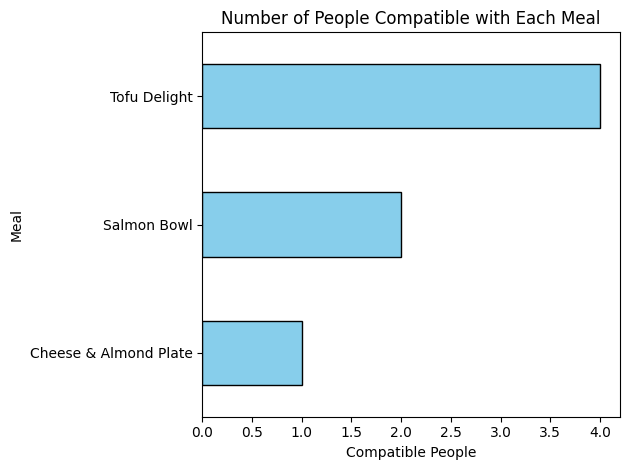

In [8]:
scores = analyzer.score_meals()
scores.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Number of People Compatible with Each Meal")
plt.xlabel("Compatible People")
plt.ylabel("Meal")
plt.tight_layout()
plt.show()

### 🔍 Heatmap of Compatibility Matrix

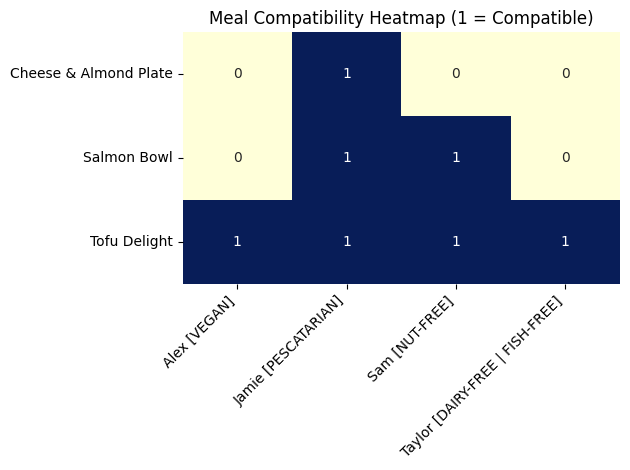

In [9]:
matrix = analyzer.get_matrix().astype(int)
sns.heatmap(matrix, annot=True, cmap="YlGnBu", cbar=False)
plt.title("Meal Compatibility Heatmap (1 = Compatible)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 6. Explore Tags by Category

Tags can be grouped by category for filtering or display.

In [10]:

print("\n=== Tags by Category ===")
print("Ethical:", tag_registry.get_tags_by_category("ethical"))
print("Allergen:", tag_registry.get_tags_by_category("allergen"))


=== Tags by Category ===
Ethical: ['VEGAN', 'VEGETARIAN', 'PESCATARIAN']
Allergen: ['NUT-FREE', 'DAIRY-FREE']


## 7. Natural Language Parsing

This library also allows for the parsing of natural descriptor strings for generating DietaryRestriction objects. It also uses fuzzy logic to handle misspellings (useful if gathering information from forms)

In [11]:
samples = [
    "Vegetarian and dairy free",
    "No restrictions",
    "Lactose intollerant",
    "vegan (no milk, egg, meat)",
    "Shellfish and peenut allergy",
    "I can eat everything"
]

parsed = [parse_freeform_restriction(s, return_debug=True) for s in samples]

# Display results
for (restriction, debug) in parsed:
    print(f"Input: {debug['input']}")
    print(f"  Matched: {debug['matched_terms']}")
    print(f"  Fuzzy:   {debug['fuzzy_matches']}")
    print(f"  Exclusions: {debug['exclusions']}")
    print(f"  Reason: {debug['reason']}")
    print("---")

Input: Vegetarian and dairy free
  Matched: ['vegetarian', 'dairy']
  Fuzzy:   []
  Exclusions: ['DAIRY', 'FISH', 'MEAT', 'SHELLFISH']
  Reason: Matched exclusions via keyword and/or fuzzy matching
---
Input: No restrictions
  Matched: []
  Fuzzy:   []
  Exclusions: []
  Reason: No exclusions matched
---
Input: Lactose intollerant
  Matched: ['lactose']
  Fuzzy:   []
  Exclusions: ['DAIRY']
  Reason: Matched exclusions via keyword and/or fuzzy matching
---
Input: vegan (no milk, egg, meat)
  Matched: ['vegan', 'milk', 'egg', 'meat']
  Fuzzy:   []
  Exclusions: ['ANIMAL_PRODUCTS', 'DAIRY', 'EGGS', 'MEAT']
  Reason: Matched exclusions via keyword and/or fuzzy matching
---
Input: Shellfish and peenut allergy
  Matched: ['shellfish']
  Fuzzy:   []
  Exclusions: ['SHELLFISH']
  Reason: Matched exclusions via keyword and/or fuzzy matching
---
Input: I can eat everything
  Matched: []
  Fuzzy:   []
  Exclusions: []
  Reason: Matched known unrestricted phrase
---
